# BATTING

In [13]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_batting_impact, load_season_perf
batting_stats = load_batting_impact()
df_season_perf = load_season_perf()

## For a few - all data

In [ ]:
def calculate_player_risk(player_name, impact_df, metric='Batting_Impact_Score', n_simulations=10000, confidence_level=0.95):
    """
    Calculates VaR and CVaR for a player's impact score using Monte Carlo simulation.
    
    Parameters:
    player_name (str): Name of the player to analyze
    impact_df (DataFrame): DataFrame containing player impact scores by season
    metric (str): Which impact score to use ('Batting_Impact_Score' or 'Bowling_Impact_Score')
    n_simulations (int): Number of Monte Carlo simulations to run
    confidence_level (float): Confidence level for VaR calculation (e.g., 0.95 for 95%)
    
    Returns:
    dict: Dictionary containing risk metrics and simulation results
    """
    
    # Get the player's historical impact scores
    player_data = impact_df[impact_df['Player'] == player_name].sort_values('Season')
    
    if len(player_data) < 3:
        print(f"Not enough data for {player_name}. Need at least 3 seasons.")
        return None
    
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data[metric].values
    returns = np.diff(scores) / scores[:-1]  # Percentage change year-to-year
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    
    # Get the most recent score as our starting point
    current_score = scores[-1]
    
    # Monte Carlo Simulation: Simulate next season's return
    simulated_returns = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores = current_score * (1 + simulated_returns)
    
    # Calculate VaR and CVaR
    # For VaR, we look at the LOSS (negative return) distribution
    simulated_losses = current_score - simulated_scores  # This is the "dollar" loss in impact points
    
    # Value at Risk (VaR) - the threshold loss that won't be exceeded with (confidence_level)% confidence
    var = np.percentile(simulated_losses, confidence_level * 100)
    
    # Conditional VaR (CVaR) - average loss in the worst (1-confidence_level)% of cases
    worst_losses = simulated_losses[simulated_losses >= var]
    cvar = np.mean(worst_losses) if len(worst_losses) > 0 else var
    
    # Calculate expected score and volatility for context
    expected_score = np.mean(simulated_scores)
    score_volatility = np.std(simulated_scores)
    
    return {
        'player': player_name,
        'current_score': current_score,
        'expected_score': expected_score,
        'score_volatility': score_volatility,
        'var': var,
        'cvar': cvar,
        'confidence_level': confidence_level,
        'historical_scores': scores,
        'simulated_scores': simulated_scores,
        'simulated_losses': simulated_losses
    }


In [65]:

test_players = ["SP Narine","AD Russell","V Kohli", "RG Sharma", "DA Warner", "MS Dhoni"]  # Use exact names from your data

player_risk_results = {}

for player in test_players:
    print(f"\nAnalyzing risk for {player}...")
    result = calculate_player_risk(player, batting_stats, 'Batting_Impact_Score')
    if result:
        player_risk_results[player] = result
        print(f"  Current Impact Score: {result['current_score']:.2f}")
        print(f"  Expected Next Season: {result['expected_score']:.2f}")
        print(f"  Volatility: {result['score_volatility']:.2f}")
        print(f"  VaR ({result['confidence_level']*100:.0f}%): {result['var']:.2f}")
        print(f"  CVaR: {result['cvar']:.2f}")



Analyzing risk for SP Narine...
  Current Impact Score: 35.27
  Expected Next Season: nan
  Volatility: nan
  VaR (95%): nan
  CVaR: nan

Analyzing risk for AD Russell...
  Current Impact Score: 28.24
  Expected Next Season: 99.46
  Volatility: 252.63
  VaR (95%): 345.13
  CVaR: 442.46

Analyzing risk for V Kohli...
  Current Impact Score: 73.58
  Expected Next Season: 83.20
  Volatility: 30.59
  VaR (95%): 40.93
  CVaR: 53.46

Analyzing risk for RG Sharma...
  Current Impact Score: 49.24
  Expected Next Season: 50.26
  Volatility: 11.88
  VaR (95%): 18.73
  CVaR: 23.92

Analyzing risk for DA Warner...
  Current Impact Score: 28.84
  Expected Next Season: 29.72
  Volatility: 8.65
  VaR (95%): 13.31
  CVaR: 16.78

Analyzing risk for MS Dhoni...
  Current Impact Score: 29.58
  Expected Next Season: 29.55
  Volatility: 7.97
  VaR (95%): 13.32
  CVaR: 16.59


C:\Users\ASUS\AppData\Local\Temp\ipykernel_50964\4284858555.py:25: RuntimeWarning: divide by zero encountered in divide
  returns = np.diff(scores) / scores[:-1]  # Percentage change year-to-year
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [4]:
def plot_risk_analysis(result):
    """Plot the Monte Carlo simulation results for a player"""
    if not result:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Historical performance
    seasons = range(len(result['historical_scores']))
    ax1.plot(seasons, result['historical_scores'], 'bo-', label='Historical Scores')
    ax1.axhline(y=result['current_score'], color='r', linestyle='--', label='Current Score')
    ax1.axhline(y=result['expected_score'], color='g', linestyle='--', label='Expected Next Season')
    ax1.set_xlabel('Seasons')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{result["player"]} - Historical Performance')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Monte Carlo simulation results
    ax2.hist(result['simulated_scores'], bins=50, alpha=0.7, label='Simulated Scores')
    ax2.axvline(x=result['current_score'] - result['var'], color='r', linestyle='--', 
                label=f'VaR ({result["confidence_level"]*100:.0f}%): {result["var"]:.2f}')
    ax2.axvline(x=result['current_score'] - result['cvar'], color='darkred', linestyle='--',
                label=f'CVaR: {result["cvar"]:.2f}')
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{result["player"]} - Monte Carlo Simulation (n=10,000)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\axes\_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

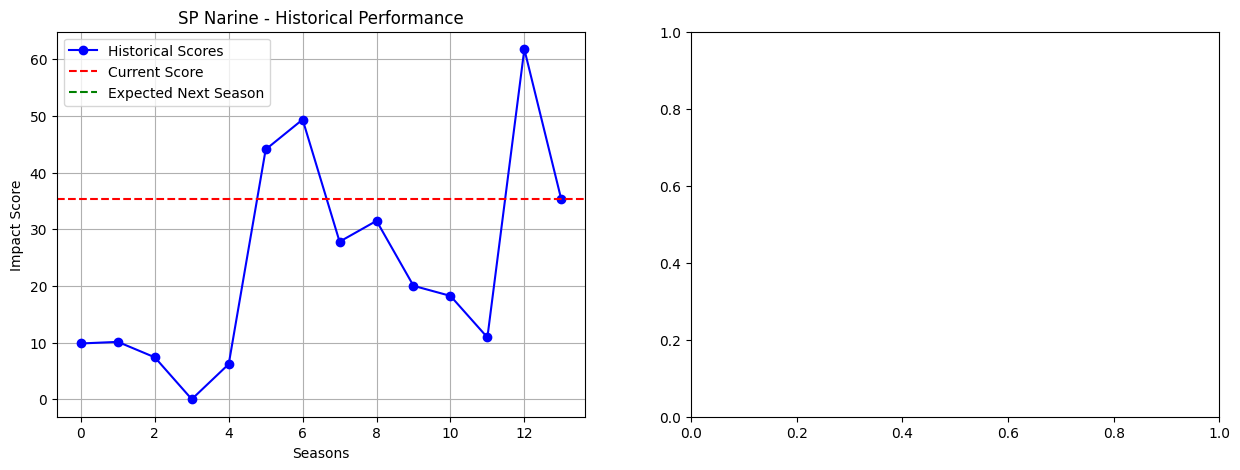

In [66]:

# Plot results for the first player
if player_risk_results:
    plot_risk_analysis(list(player_risk_results.values())[0])


## For Testing - all data

=== ANALYZING RISK FOR AD Russell ===

Historical data found for AD Russell:
 Season  Batting_Impact_Score
   2012             17.942899
   2013              6.989695
   2014              1.946475
   2015             65.184818
   2016             34.230618
   2018             46.877846
   2019             67.277555
   2020             31.354930
   2021             37.938658
   2022             42.321227
   2023             35.106676
   2024             40.507760
   2025             28.238294

Number of seasons: 13

Raw Impact Scores: [17.94289924  6.98969499  1.94647452 65.18481808 34.23061765 46.87784619
 67.27755457 31.35492983 37.93865792 42.32122693 35.1066758  40.50775978
 28.23829446]
Year-to-Year Percentage Changes: [-0.61044785 -0.72152225 32.48865734 -0.47486825  0.36947123  0.43516736
 -0.53394665  0.20997426  0.11551724 -0.17047122  0.15384778 -0.30289173]

Average Yearly Change: 2.580 (258.0%)
Volatility of Changes (Std Dev): 9.026 (902.6%)

Most Recent Impact Score (2025):

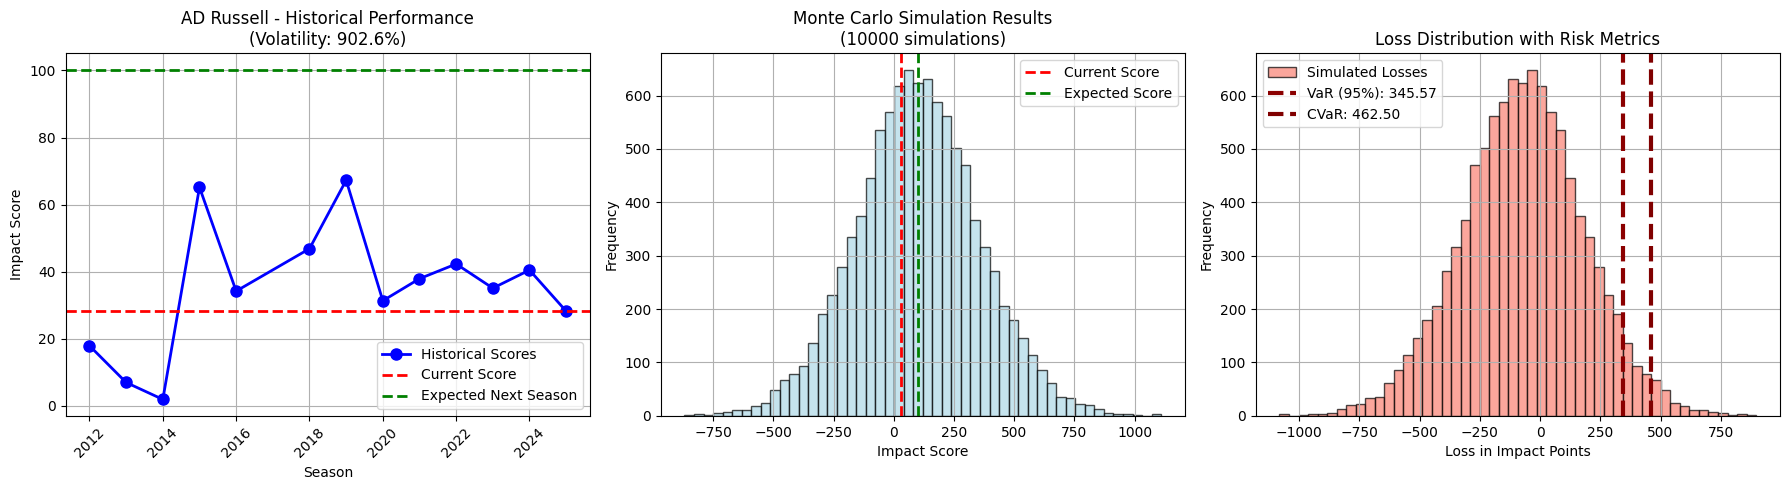

In [44]:
# region [MONTE CARLO SIMULATION FOR DAVID WARNER - WITH DETAILED PRINTS]

# Let's use David Warner as our example player
player_name = "AD Russell"  # Make sure this matches exactly how his name appears in your data
print(f"=== ANALYZING RISK FOR {player_name} ===\n")

# Get the player's historical impact scores
player_data = batting_stats[batting_stats['Player'] == player_name].sort_values('Season')
print(f"Historical data found for {player_name}:")
print(player_data[['Season', 'Batting_Impact_Score']].to_string(index=False))
print(f"\nNumber of seasons: {len(player_data)}")

if len(player_data) < 3:
    print(f"Not enough data for {player_name}. Need at least 3 seasons.")
else:
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data['Batting_Impact_Score'].values
    print(f"\nRaw Impact Scores: {scores}")
    
    # Calculate percentage changes between seasons
    returns = np.diff(scores) / scores[:-1]
    print(f"Year-to-Year Percentage Changes: {returns}")
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    print(f"\nAverage Yearly Change: {mean_return:.3f} ({mean_return*100:.1f}%)")
    print(f"Volatility of Changes (Std Dev): {std_return:.3f} ({std_return*100:.1f}%)")
    
    # Get the most recent score as our starting point
    current_score = scores[-1]
    print(f"\nMost Recent Impact Score ({player_data['Season'].iloc[-1]}): {current_score:.2f}")
    
    # Monte Carlo Simulation: Simulate next season's return
    n_simulations = 10000
    print(f"\nRunning {n_simulations} Monte Carlo simulations...")
    
    simulated_returns = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores = current_score * (1 + simulated_returns)
    
    print(f"First 10 Simulated Returns: {simulated_returns[:10]}")
    print(f"First 10 Simulated Scores: {simulated_scores[:10]}")
    
    # Calculate VaR and CVaR
    simulated_losses = current_score - simulated_scores
    print(f"First 10 Simulated Losses: {simulated_losses[:10]}")
    
    confidence_level = 0.95
    var = np.percentile(simulated_losses, confidence_level * 100)
    
    # Get the worst losses (beyond the VaR threshold)
    worst_losses = simulated_losses[simulated_losses >= var]
    cvar = np.mean(worst_losses) if len(worst_losses) > 0 else var
    
    print(f"\n=== RISK ANALYSIS RESULTS ===")
    print(f"Player: {player_name}")
    print(f"Current Impact Score: {current_score:.2f}")
    print(f"Expected Next Season Score: {np.mean(simulated_scores):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar:.2f} points")
    
    # Interpretation
    print(f"\n=== INTERPRETATION ===")
    print(f"There is a {confidence_level*100:.0f}% chance that {player_name} will not lose more than {var:.2f} impact points next season.")
    print(f"In the worst {(1-confidence_level)*100:.0f}% of scenarios, his performance drops by an average of {cvar:.2f} points.")

# endregion

# region [VISUALIZE THE RESULTS]
if len(player_data) >= 3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Historical performance
    seasons = player_data['Season'].values
    ax1.plot(seasons, scores, 'bo-', label='Historical Scores', markersize=8, linewidth=2)
    ax1.axhline(y=current_score, color='r', linestyle='--', label='Current Score', linewidth=2)
    ax1.axhline(y=np.mean(simulated_scores), color='g', linestyle='--', label='Expected Next Season', linewidth=2)
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{player_name} - Historical Performance\n(Volatility: {std_return*100:.1f}%)')
    ax1.legend()
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Monte Carlo simulation results (scores)
    ax2.hist(simulated_scores, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    ax2.axvline(x=current_score, color='r', linestyle='--', label='Current Score', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores), color='g', linestyle='--', label='Expected Score', linewidth=2)
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Monte Carlo Simulation Results\n({n_simulations} simulations)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Loss distribution with VaR and CVaR
    ax3.hist(simulated_losses, bins=50, alpha=0.7, color='salmon', edgecolor='black', label='Simulated Losses')
    ax3.axvline(x=var, color='darkred', linestyle='--', linewidth=3, 
                label=f'VaR ({confidence_level*100:.0f}%): {var:.2f}')
    ax3.axvline(x=cvar, color='maroon', linestyle='--', linewidth=3,
                label=f'CVaR: {cvar:.2f}')
    ax3.set_xlabel('Loss in Impact Points')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Loss Distribution with Risk Metrics')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# endregion

=== ANALYZING RISK FOR DA Warner ===

Using data up to 2021 to predict 2021 season...

Historical data found for DA Warner (up to 2021):
 Season  Batting_Impact_Score
   2009             37.879026
   2010             50.130942
   2011             49.210552
   2012             35.565131
   2013             47.745170
   2014             66.503504
   2015             86.231600
   2016             79.721774
   2017             89.762556
   2019             80.770790
   2020             71.931303
   2021             35.373909

Number of seasons: 12

Raw Impact Scores: [37.87902574 50.13094194 49.2105522  35.56513129 47.74517023 66.50350404
 86.23160015 79.7217736  89.76255603 80.77079002 71.93130304 35.37390887]
Year-to-Year Percentage Changes: [ 0.32344856 -0.01835971 -0.27728648  0.34247136  0.39288443  0.29664747
 -0.07549235  0.12594781 -0.10017279 -0.10943915 -0.5082265 ]

Average Yearly Change: 0.036 (3.6%)
Volatility of Changes (Std Dev): 0.275 (27.5%)

Most Recent Impact Score (2021

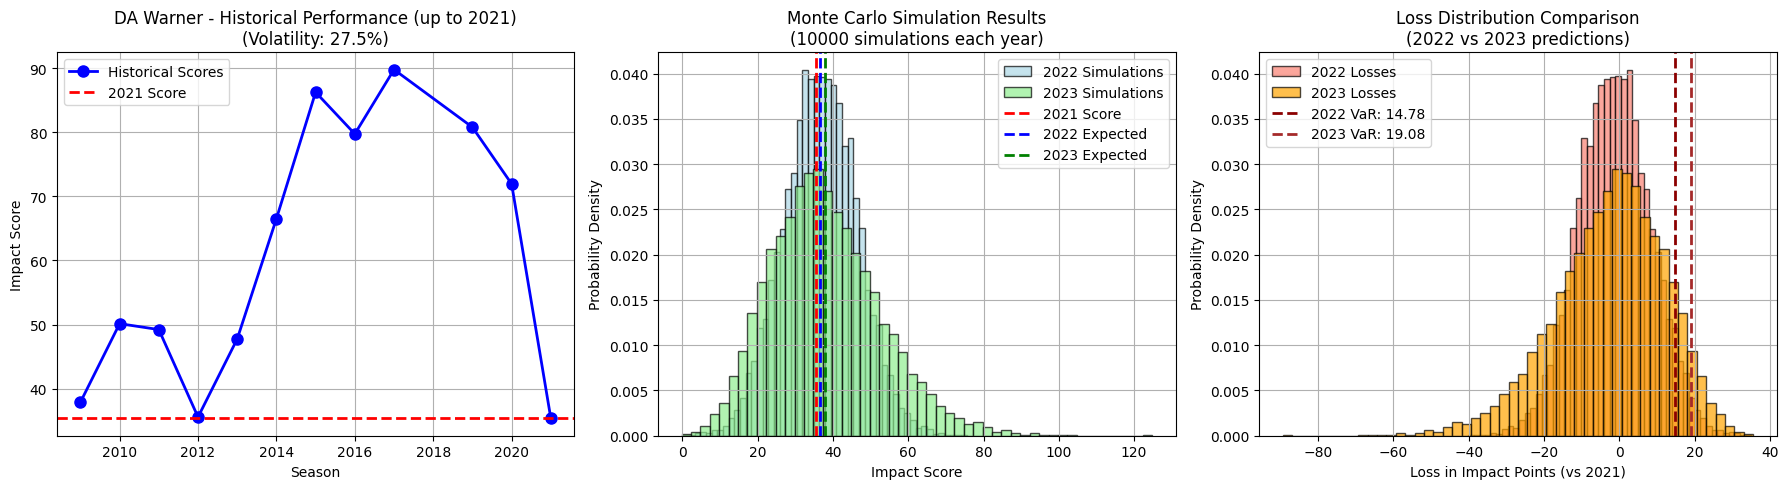

In [12]:
# region [MONTE CARLO SIMULATION - PREDICTING FUTURE SEASONS]

# Let's use David Warner as our example player
player_name = "DA Warner"  # Make sure this matches exactly how his name appears in your data
print(f"=== ANALYZING RISK FOR {player_name} ===\n")
print("Using data up to 2021 to predict 2021 season...\n")

# Get the player's historical impact scores ONLY UP TO 2021
player_data = batting_stats[batting_stats['Player'] == player_name].copy()
player_data = player_data[player_data['Season'] <= 2021].sort_values('Season')  # Filter for seasons <= 2021

print(f"Historical data found for {player_name} (up to 2021):")
print(player_data[['Season', 'Batting_Impact_Score']].to_string(index=False))
print(f"\nNumber of seasons: {len(player_data)}")

if len(player_data) < 3:
    print(f"Not enough data for {player_name}. Need at least 3 seasons.")
else:
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data['Batting_Impact_Score'].values
    print(f"\nRaw Impact Scores: {scores}")
    
    # Calculate percentage changes between seasons
    returns = np.diff(scores) / scores[:-1]
    print(f"Year-to-Year Percentage Changes: {returns}")
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    print(f"\nAverage Yearly Change: {mean_return:.3f} ({mean_return*100:.1f}%)")
    print(f"Volatility of Changes (Std Dev): {std_return:.3f} ({std_return*100:.1f}%)")
    
    # Get the most recent score as our starting point (2021 season)
    current_score = scores[-1]
    print(f"\nMost Recent Impact Score (2021): {current_score:.2f}")
    
    # Monte Carlo Simulation: Simulate next season (2022)
    n_simulations = 10000
    print(f"\nRunning {n_simulations} Monte Carlo simulations for 2022 season...")
    
    # Simulate 2022 season
    simulated_returns_2022 = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores_2022 = current_score * (1 + simulated_returns_2022)
    
    # Simulate 2023 season (using the 2022 simulated scores as base)
    print(f"Running {n_simulations} Monte Carlo simulations for 2023 season...")
    simulated_returns_2023 = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores_2023 = simulated_scores_2022 * (1 + simulated_returns_2023)
    
    # Calculate VaR and CVaR for 2022
    simulated_losses_2022 = current_score - simulated_scores_2022
    var_2022 = np.percentile(simulated_losses_2022, confidence_level * 100)
    worst_losses_2022 = simulated_losses_2022[simulated_losses_2022 >= var_2022]
    cvar_2022 = np.mean(worst_losses_2022) if len(worst_losses_2022) > 0 else var_2022
    
    # Calculate VaR and CVaR for 2023
    simulated_losses_2023 = current_score - simulated_scores_2023  # Loss from 2021 baseline
    var_2023 = np.percentile(simulated_losses_2023, confidence_level * 100)
    worst_losses_2023 = simulated_losses_2023[simulated_losses_2023 >= var_2023]
    cvar_2023 = np.mean(worst_losses_2023) if len(worst_losses_2023) > 0 else var_2023

    print(f"\n=== RISK ANALYSIS RESULTS ===")
    print(f"Player: {player_name}")
    print(f"Current Impact Score (2021): {current_score:.2f}")
    print(f"\n--- 2022 PREDICTION ---")
    print(f"Expected 2022 Score: {np.mean(simulated_scores_2022):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores_2022):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var_2022:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar_2022:.2f} points")
    
    print(f"\n--- 2023 PREDICTION ---")
    print(f"Expected 2023 Score: {np.mean(simulated_scores_2023):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores_2023):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var_2023:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar_2023:.2f} points")
    
    # Interpretation
    print(f"\n=== INTERPRETATION ===")
    print(f"2022: {confidence_level*100:.0f}% chance of not losing more than {var_2022:.2f} points vs 2021")
    print(f"2023: {confidence_level*100:.0f}% chance of not losing more than {var_2023:.2f} points vs 2021")

# endregion

# region [VISUALIZE THE RESULTS FOR BOTH YEARS]
if len(player_data) >= 3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Historical performance up to 2021
    seasons = player_data['Season'].values
    ax1.plot(seasons, scores, 'bo-', label='Historical Scores', markersize=8, linewidth=2)
    ax1.axhline(y=current_score, color='r', linestyle='--', label='2021 Score', linewidth=2)
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{player_name} - Historical Performance (up to 2021)\n(Volatility: {std_return*100:.1f}%)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Monte Carlo simulation results for 2022 and 2023
    ax2.hist(simulated_scores_2022, bins=50, alpha=0.7, color='lightblue', edgecolor='black', 
             label='2022 Simulations', density=True)
    ax2.hist(simulated_scores_2023, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', 
             label='2023 Simulations', density=True)
    ax2.axvline(x=current_score, color='r', linestyle='--', label='2021 Score', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores_2022), color='blue', linestyle='--', label='2022 Expected', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores_2023), color='green', linestyle='--', label='2023 Expected', linewidth=2)
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Probability Density')
    ax2.set_title(f'Monte Carlo Simulation Results\n({n_simulations} simulations each year)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Loss distribution comparison
    ax3.hist(simulated_losses_2022, bins=50, alpha=0.7, color='salmon', edgecolor='black', 
             label='2022 Losses', density=True)
    ax3.hist(simulated_losses_2023, bins=50, alpha=0.7, color='orange', edgecolor='black', 
             label='2023 Losses', density=True)
    ax3.axvline(x=var_2022, color='darkred', linestyle='--', linewidth=2, 
                label=f'2022 VaR: {var_2022:.2f}')
    ax3.axvline(x=var_2023, color='brown', linestyle='--', linewidth=2,
                label=f'2023 VaR: {var_2023:.2f}')
    ax3.set_xlabel('Loss in Impact Points (vs 2021)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('Loss Distribution Comparison\n(2022 vs 2023 predictions)')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# endregion

In [ ]:
# Step 1: Identify players who played in 2025
Players_2025 = df_season_perf[df_season_perf['Season'] == 2025]['Player'].unique()
print(f"Number of players who played in 2025: {len(Players_2025)}")


Number of players who played in 2025: 200


## Till 2024

In [38]:
# region [PREDICT 2025 RISK USING HISTORICAL DATA (2008-2024)]

# Step 1: Identify players who played in 2025
players_in_2025 = batting_stats[batting_stats['Season'] == 2025]['Player'].unique()
print(f"Number of players who batted in 2025: {len(players_in_2025)}")


Number of players who batted in 2025: 200


In [39]:

# Step 2: Prepare historical data (2008-2024 only)
historical_data = batting_stats[batting_stats['Season'] != 2025].copy()

# Step 3: Run Monte Carlo simulation for each player to predict 2025 risk
results_2025 = []

for player in players_in_2025:
    # Get player's historical data (excluding 2025)
    player_historical = historical_data[historical_data['Player'] == player].sort_values('Season')
    
    if len(player_historical) >= 3:  # Need sufficient data for meaningful simulation
        result = calculate_player_risk(player, historical_data, 'Batting_Impact_Score')
        if result:
            # Get their actual 2025 performance for comparison
            actual_2025 = batting_stats[(batting_stats['Player'] == player) & 
                                            (batting_stats['Season'] == 2025)]
            actual_score_2025 = actual_2025['Batting_Impact_Score'].values[0] if not actual_2025.empty else np.nan
            
            results_2025.append({
                'Player': player,
                'Seasons_Available': len(player_historical),
                'Last_Historical_Score': player_historical['Batting_Impact_Score'].iloc[-1],
                'Predicted_Expected_Score': result['expected_score'],
                'Predicted_VaR_95': result['var'],
                'Predicted_CVaR_95': result['cvar'],
                'Actual_2025_Score': actual_score_2025,
                'Prediction_Error': actual_score_2025 - result['expected_score'] if not np.isnan(actual_score_2025) else np.nan
            })
    else:
        print(f"Insufficient data for {player}: only {len(player_historical)} seasons")

# Step 4: Create the output DataFrame
risk_predictions_2025 = pd.DataFrame(results_2025)


Insufficient data for A Kamboj: only 1 seasons
Insufficient data for A Mhatre: only 0 seasons
Insufficient data for A Raghuvanshi: only 1 seasons
Insufficient data for Abishek Porel: only 2 seasons
Insufficient data for Akash Madhwal: only 2 seasons
Insufficient data for Akash Singh: only 2 seasons
Insufficient data for Aniket Verma: only 0 seasons
Insufficient data for Arshad Khan: only 2 seasons
Insufficient data for Ashutosh Sharma: only 1 seasons
Insufficient data for Ashwani Kumar: only 0 seasons
Insufficient data for Atharva Taide: only 2 seasons
Insufficient data for Azmatullah Omarzai: only 1 seasons
Insufficient data for BKG Mendis: only 0 seasons
Insufficient data for C Bosch: only 0 seasons
Insufficient data for D Brevis: only 2 seasons
Insufficient data for D Ferreira: only 1 seasons
Insufficient data for DP Conway: only 2 seasons
Insufficient data for DS Rathi: only 0 seasons
Insufficient data for Dhruv Jurel: only 2 seasons
Insufficient data for E Malinga: only 0 seasons


C:\Users\ASUS\AppData\Local\Temp\ipykernel_50964\1387682346.py:25: RuntimeWarning: divide by zero encountered in divide
  returns = np.diff(scores) / scores[:-1]  # Percentage change year-to-year
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_50964\1387682346.py:25: RuntimeWarning: invalid value encountered in divide
  returns = np.diff(scores) / scores[:-1]  # Percentage change year-to-year


Insufficient data for M Siddharth: only 1 seasons
Insufficient data for M Tiwari: only 0 seasons
Insufficient data for MJ Owen: only 0 seasons
Insufficient data for MP Breetzke: only 0 seasons
Insufficient data for MP Yadav: only 1 seasons
Insufficient data for MS Bhandage: only 0 seasons
Insufficient data for Mukesh Choudhary: only 2 seasons
Insufficient data for Mukesh Kumar: only 2 seasons
Insufficient data for Musheer Khan: only 0 seasons
Insufficient data for N Thushara: only 1 seasons
Insufficient data for N Wadhera: only 2 seasons
Insufficient data for Naman Dhir: only 1 seasons
Insufficient data for Nithish Kumar Reddy: only 2 seasons
Insufficient data for Noor Ahmad: only 2 seasons
Insufficient data for P Dubey: only 2 seasons
Insufficient data for PD Salt: only 2 seasons
Insufficient data for PHKD Mendis: only 0 seasons
Insufficient data for PVD Chameera: only 2 seasons
Insufficient data for PVSN Raju: only 0 seasons
Insufficient data for PWA Mulder: only 0 seasons
Insufficie

In [40]:
risk_predictions_2025.head(10)

,Player,Seasons_Available,Last_Historical_Score,Predicted_Expected_Score,Predicted_VaR_95,Predicted_CVaR_95,Actual_2025_Score,Prediction_Error
0,A Badoni,3,36.129620,46.034067,6.823443,11.123919,42.841422,-3.192645
1,A Manohar,3,6.281630,4.829283,6.830813,8.267655,13.879666,9.050383
2,A Nortje,5,4.875169,NaN,NaN,NaN,0.000000,NaN
3,A Zampa,4,7.977742,NaN,NaN,NaN,0.000000,NaN
4,AD Russell,12,40.507760,158.046291,505.564124,661.467368,28.238294,-129.807997
5,AK Markram,4,32.872435,34.748820,14.327556,18.343050,52.357079,17.608259
6,AM Rahane,16,33.762462,57.944991,106.770841,138.512331,48.221990,-9.723001
7,AR Patel,11,35.617788,46.744133,33.758523,45.082771,36.685629,-10.058503
8,AS Roy,4,8.576248,NaN,NaN,NaN,0.000000,NaN
9,Abdul Samad,5,32.668941,82.509086,122.761498,167.492937,28.703505,-53.805581


In [45]:
risk_predictions_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Player                    116 non-null    object 
 1   Seasons_Available         116 non-null    int64  
 2   Last_Historical_Score     116 non-null    float64
 3   Predicted_Expected_Score  65 non-null     float64
 4   Predicted_VaR_95          65 non-null     float64
 5   Predicted_CVaR_95         65 non-null     float64
 6   Actual_2025_Score         116 non-null    float64
 7   Prediction_Error          65 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.4+ KB



Successfully analyzed 116 players

Top 10 players with highest predicted risk (VaR):
           Player  Predicted_VaR_95  VaR_Relative_Pct
4      AD Russell        505.564124       1248.067349
24      H Klaasen        198.462231        326.860806
104      TH David        148.481124        385.463428
9     Abdul Samad        122.761498        375.774343
6       AM Rahane        106.770841        316.241274
96        SS Iyer        100.270921        208.205702
73      Q de Kock         92.593074        258.536882
75        R Parag         81.654299        118.598867
57      MK Pandey         81.038828        355.932144
30   Ishan Kishan         60.567228        141.811622

Top 10 players with lowest predicted risk (VaR):
                Player  Predicted_VaR_95  VaR_Relative_Pct
102           T Stubbs       -125.143318       -213.439459
105            TM Head        -45.641913        -65.518880
72        PWH de Silva        -14.686278        -80.615475
107        Tilak Varma         -4.

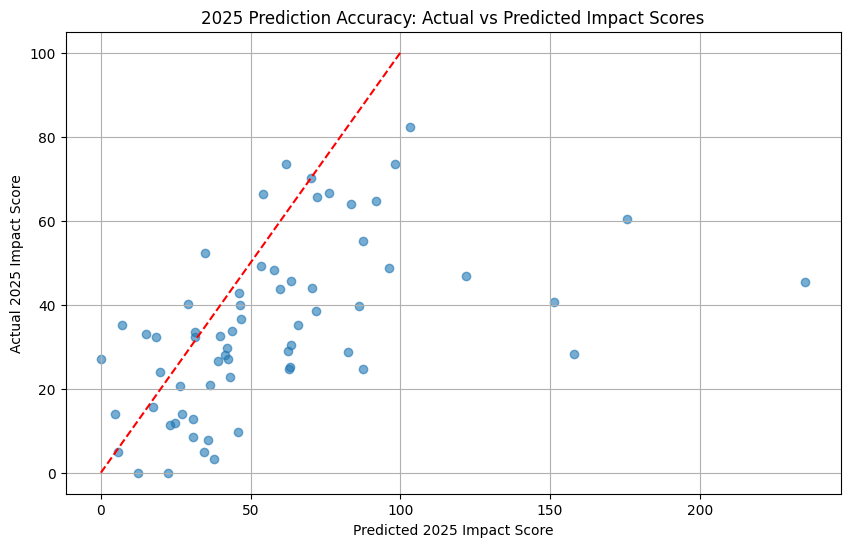

In [46]:

# Calculate additional risk metrics
risk_predictions_2025['VaR_Relative_Pct'] = (risk_predictions_2025['Predicted_VaR_95'] / 
                                           risk_predictions_2025['Last_Historical_Score']) * 100
risk_predictions_2025['CVaR_Relative_Pct'] = (risk_predictions_2025['Predicted_CVaR_95'] / 
                                            risk_predictions_2025['Last_Historical_Score']) * 100

# Step 5: Analyze the results
print(f"\nSuccessfully analyzed {len(risk_predictions_2025)} players")
print("\nTop 10 players with highest predicted risk (VaR):")
print(risk_predictions_2025.sort_values('Predicted_VaR_95', ascending=False).head(10)[['Player', 'Predicted_VaR_95', 'VaR_Relative_Pct']])

print("\nTop 10 players with lowest predicted risk (VaR):")
print(risk_predictions_2025.sort_values('Predicted_VaR_95').head(10)[['Player', 'Predicted_VaR_95', 'VaR_Relative_Pct']])

# Step 6: Display the complete prediction DataFrame
print("\nComplete 2025 Risk Prediction DataFrame:")
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
print(risk_predictions_2025[['Player', 'Seasons_Available', 'Last_Historical_Score', 
                           'Predicted_Expected_Score', 'Predicted_VaR_95', 'Predicted_CVaR_95',
                           'VaR_Relative_Pct', 'Actual_2025_Score', 'Prediction_Error']].sort_values('Predicted_VaR_95', ascending=False))

# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.float_format')

# endregion

# region [ANALYZE PREDICTION ACCURACY]
# Check how well our predictions matched reality for 2025
if not risk_predictions_2025['Prediction_Error'].isna().all():
    mean_error = risk_predictions_2025['Prediction_Error'].mean()
    mean_absolute_error = risk_predictions_2025['Prediction_Error'].abs().mean()
    rmse = np.sqrt((risk_predictions_2025['Prediction_Error'] ** 2).mean())
    
    print(f"\nPrediction Accuracy Analysis:")
    print(f"Mean Error: {mean_error:.2f} (negative = average overprediction)")
    print(f"Mean Absolute Error: {mean_absolute_error:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(risk_predictions_2025['Predicted_Expected_Score'], 
                risk_predictions_2025['Actual_2025_Score'], alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.xlabel('Predicted 2025 Impact Score')
    plt.ylabel('Actual 2025 Impact Score')
    plt.title('2025 Prediction Accuracy: Actual vs Predicted Impact Scores')
    plt.grid(True)
    plt.show()
else:
    print("No actual 2025 data available for accuracy analysis")

# endregion

In [51]:
df_sorted = risk_predictions_2025.sort_values(by="Prediction_Error", ascending=False)

df_sorted.head(20)

,Player,Seasons_Available,Last_Historical_Score,Predicted_Expected_Score,Predicted_VaR_95,Predicted_CVaR_95,Actual_2025_Score,Prediction_Error,VaR_Relative_Pct,CVaR_Relative_Pct
18,D Padikkal,5,10.095722,7.079423,7.534320,8.660084,35.254469,28.175046,74.628840,85.779742
112,Washington Sundar,8,0.000000,0.000000,0.000000,0.000000,27.025798,27.025798,NaN,NaN
42,KK Nair,9,8.414316,14.929819,23.111323,30.266609,32.922308,17.992490,274.666687,359.703741
5,AK Markram,4,32.872435,34.748820,14.327556,18.343050,52.357079,17.608259,43.585320,55.800703
68,N Rana,9,17.733389,18.507232,11.462015,14.520762,32.269143,13.761911,64.635219,81.883740
32,JC Buttler,9,48.471792,53.981924,24.691399,32.384902,66.475431,12.493507,50.939727,66.811853
100,Shubman Gill,7,54.225217,61.880905,28.913895,37.873274,73.590738,11.709833,53.321862,69.844394
36,JM Sharma,3,29.385110,29.182043,14.512301,18.345659,40.234765,11.052722,49.386580,62.431820
1,A Manohar,3,6.281630,4.829283,6.830813,8.267655,13.879666,9.050383,108.742693,131.616398
54,MA Agarwal,14,17.615834,19.662850,13.724344,17.748237,24.074533,4.411684,77.909136,100.751609


# BOWLING

In [52]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_bowling_impact, load_season_perf
bowling_stats = load_bowling_impact()
df_season_perf = load_season_perf()

## For a few - all data

In [54]:
def calculate_player_risk(player_name, impact_df, metric='Bowling_Impact_Score', n_simulations=10000, confidence_level=0.95):
    """
    Calculates VaR and CVaR for a player's impact score using Monte Carlo simulation.
    
    Parameters:
    player_name (str): Name of the player to analyze
    impact_df (DataFrame): DataFrame containing player impact scores by season
    metric (str): Which impact score to use ('Bowling_Impact_Score' or 'Bowling_Impact_Score')
    n_simulations (int): Number of Monte Carlo simulations to run
    confidence_level (float): Confidence level for VaR calculation (e.g., 0.95 for 95%)
    
    Returns:
    dict: Dictionary containing risk metrics and simulation results
    """
    
    # Get the player's historical impact scores
    player_data = impact_df[impact_df['Player'] == player_name].sort_values('Season')
    
    if len(player_data) < 3:
        print(f"Not enough data for {player_name}. Need at least 3 seasons.")
        return None
    
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data[metric].values
    returns = np.diff(scores) / scores[:-1]  # Percentage change year-to-year
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    
    # Get the most recent score as our starting point
    current_score = scores[-1]
    
    # Monte Carlo Simulation: Simulate next season's return
    simulated_returns = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores = current_score * (1 + simulated_returns)
    
    # Calculate VaR and CVaR
    # For VaR, we look at the LOSS (negative return) distribution
    simulated_losses = current_score - simulated_scores  # This is the "dollar" loss in impact points
    
    # Value at Risk (VaR) - the threshold loss that won't be exceeded with (confidence_level)% confidence
    var = np.percentile(simulated_losses, confidence_level * 100)
    
    # Conditional VaR (CVaR) - average loss in the worst (1-confidence_level)% of cases
    worst_losses = simulated_losses[simulated_losses >= var]
    cvar = np.mean(worst_losses) if len(worst_losses) > 0 else var
    
    # Calculate expected score and volatility for context
    expected_score = np.mean(simulated_scores)
    score_volatility = np.std(simulated_scores)
    
    return {
        'player': player_name,
        'current_score': current_score,
        'expected_score': expected_score,
        'score_volatility': score_volatility,
        'var': var,
        'cvar': cvar,
        'confidence_level': confidence_level,
        'historical_scores': scores,
        'simulated_scores': simulated_scores,
        'simulated_losses': simulated_losses
    }


In [67]:

test_players = ["SP Narine","AD Russell"]  # Use exact names from your data

player_risk_results = {}

for player in test_players:
    print(f"\nAnalyzing risk for {player}...")
    result = calculate_player_risk(player, bowling_stats, 'Bowling_Impact_Score')
    if result:
        player_risk_results[player] = result
        print(f"  Current Impact Score: {result['current_score']:.2f}")
        print(f"  Expected Next Season: {result['expected_score']:.2f}")
        print(f"  Volatility: {result['score_volatility']:.2f}")
        print(f"  VaR ({result['confidence_level']*100:.0f}%): {result['var']:.2f}")
        print(f"  CVaR: {result['cvar']:.2f}")



Analyzing risk for SP Narine...
  Current Impact Score: 62.58
  Expected Next Season: 63.92
  Volatility: 20.60
  VaR (95%): 33.12
  CVaR: 41.12

Analyzing risk for AD Russell...
  Current Impact Score: 49.74
  Expected Next Season: nan
  Volatility: nan
  VaR (95%): nan
  CVaR: nan


In [56]:
def plot_risk_analysis(result):
    """Plot the Monte Carlo simulation results for a player"""
    if not result:
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Historical performance
    seasons = range(len(result['historical_scores']))
    ax1.plot(seasons, result['historical_scores'], 'bo-', label='Historical Scores')
    ax1.axhline(y=result['current_score'], color='r', linestyle='--', label='Current Score')
    ax1.axhline(y=result['expected_score'], color='g', linestyle='--', label='Expected Next Season')
    ax1.set_xlabel('Seasons')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{result["player"]} - Historical Performance')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Monte Carlo simulation results
    ax2.hist(result['simulated_scores'], bins=50, alpha=0.7, label='Simulated Scores')
    ax2.axvline(x=result['current_score'] - result['var'], color='r', linestyle='--', 
                label=f'VaR ({result["confidence_level"]*100:.0f}%): {result["var"]:.2f}')
    ax2.axvline(x=result['current_score'] - result['cvar'], color='darkred', linestyle='--',
                label=f'CVaR: {result["cvar"]:.2f}')
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'{result["player"]} - Monte Carlo Simulation (n=10,000)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


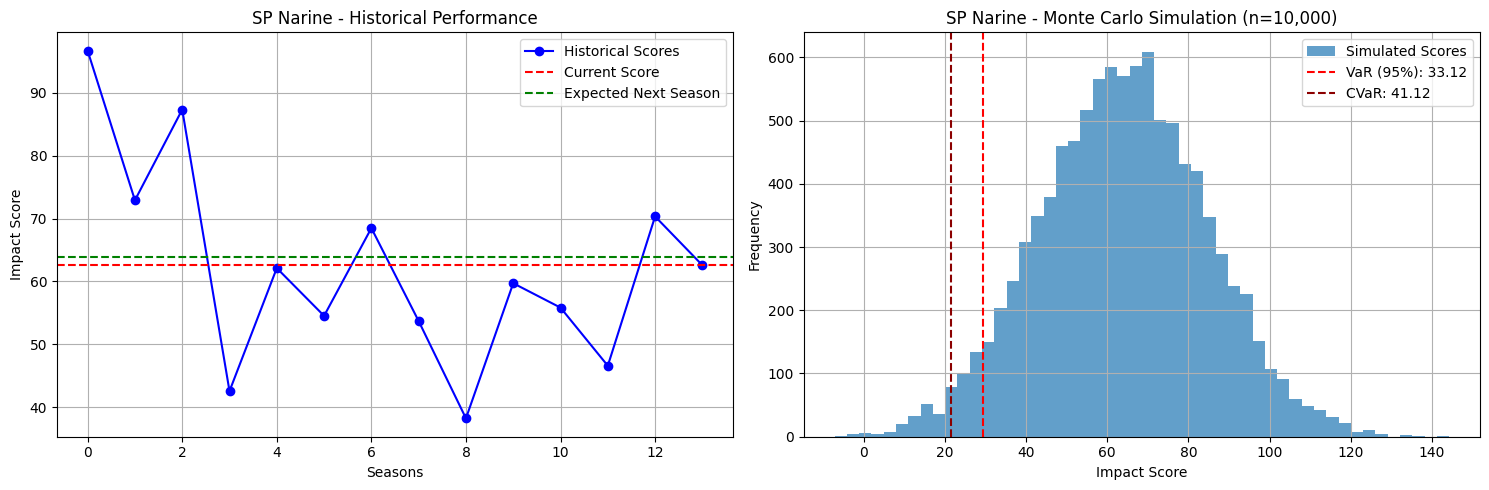

In [68]:

# Plot results for the first player
if player_risk_results:
    plot_risk_analysis(list(player_risk_results.values())[0])


## For Testing - all data

In [58]:
# region [MONTE CARLO SIMULATION FOR DAVID WARNER - WITH DETAILED PRINTS]

# Let's use David Warner as our example player
player_name = "AD Russell"  # Make sure this matches exactly how his name appears in your data
print(f"=== ANALYZING RISK FOR {player_name} ===\n")

# Get the player's historical impact scores
player_data = bowling_stats[bowling_stats['Player'] == player_name].sort_values('Season')
print(f"Historical data found for {player_name}:")
print(player_data[['Season', 'bowling_Impact_Score']].to_string(index=False))
print(f"\nNumber of seasons: {len(player_data)}")

if len(player_data) < 3:
    print(f"Not enough data for {player_name}. Need at least 3 seasons.")
else:
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data['bowling_Impact_Score'].values
    print(f"\nRaw Impact Scores: {scores}")
    
    # Calculate percentage changes between seasons
    returns = np.diff(scores) / scores[:-1]
    print(f"Year-to-Year Percentage Changes: {returns}")
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    print(f"\nAverage Yearly Change: {mean_return:.3f} ({mean_return*100:.1f}%)")
    print(f"Volatility of Changes (Std Dev): {std_return:.3f} ({std_return*100:.1f}%)")
    
    # Get the most recent score as our starting point
    current_score = scores[-1]
    print(f"\nMost Recent Impact Score ({player_data['Season'].iloc[-1]}): {current_score:.2f}")
    
    # Monte Carlo Simulation: Simulate next season's return
    n_simulations = 10000
    print(f"\nRunning {n_simulations} Monte Carlo simulations...")
    
    simulated_returns = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores = current_score * (1 + simulated_returns)
    
    print(f"First 10 Simulated Returns: {simulated_returns[:10]}")
    print(f"First 10 Simulated Scores: {simulated_scores[:10]}")
    
    # Calculate VaR and CVaR
    simulated_losses = current_score - simulated_scores
    print(f"First 10 Simulated Losses: {simulated_losses[:10]}")
    
    confidence_level = 0.95
    var = np.percentile(simulated_losses, confidence_level * 100)
    
    # Get the worst losses (beyond the VaR threshold)
    worst_losses = simulated_losses[simulated_losses >= var]
    cvar = np.mean(worst_losses) if len(worst_losses) > 0 else var
    
    print(f"\n=== RISK ANALYSIS RESULTS ===")
    print(f"Player: {player_name}")
    print(f"Current Impact Score: {current_score:.2f}")
    print(f"Expected Next Season Score: {np.mean(simulated_scores):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar:.2f} points")
    
    # Interpretation
    print(f"\n=== INTERPRETATION ===")
    print(f"There is a {confidence_level*100:.0f}% chance that {player_name} will not lose more than {var:.2f} impact points next season.")
    print(f"In the worst {(1-confidence_level)*100:.0f}% of scenarios, his performance drops by an average of {cvar:.2f} points.")

# endregion

# region [VISUALIZE THE RESULTS]
if len(player_data) >= 3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Historical performance
    seasons = player_data['Season'].values
    ax1.plot(seasons, scores, 'bo-', label='Historical Scores', markersize=8, linewidth=2)
    ax1.axhline(y=current_score, color='r', linestyle='--', label='Current Score', linewidth=2)
    ax1.axhline(y=np.mean(simulated_scores), color='g', linestyle='--', label='Expected Next Season', linewidth=2)
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{player_name} - Historical Performance\n(Volatility: {std_return*100:.1f}%)')
    ax1.legend()
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Monte Carlo simulation results (scores)
    ax2.hist(simulated_scores, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
    ax2.axvline(x=current_score, color='r', linestyle='--', label='Current Score', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores), color='g', linestyle='--', label='Expected Score', linewidth=2)
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Monte Carlo Simulation Results\n({n_simulations} simulations)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Loss distribution with VaR and CVaR
    ax3.hist(simulated_losses, bins=50, alpha=0.7, color='salmon', edgecolor='black', label='Simulated Losses')
    ax3.axvline(x=var, color='darkred', linestyle='--', linewidth=3, 
                label=f'VaR ({confidence_level*100:.0f}%): {var:.2f}')
    ax3.axvline(x=cvar, color='maroon', linestyle='--', linewidth=3,
                label=f'CVaR: {cvar:.2f}')
    ax3.set_xlabel('Loss in Impact Points')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Loss Distribution with Risk Metrics')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# endregion

=== ANALYZING RISK FOR AD Russell ===

Historical data found for AD Russell:


KeyError: "['bowling_Impact_Score'] not in index"

=== ANALYZING RISK FOR DA Warner ===

Using data up to 2021 to predict 2021 season...

Historical data found for DA Warner (up to 2021):
 Season  Batting_Impact_Score
   2009             37.879026
   2010             50.130942
   2011             49.210552
   2012             35.565131
   2013             47.745170
   2014             66.503504
   2015             86.231600
   2016             79.721774
   2017             89.762556
   2019             80.770790
   2020             71.931303
   2021             35.373909

Number of seasons: 12

Raw Impact Scores: [37.87902574 50.13094194 49.2105522  35.56513129 47.74517023 66.50350404
 86.23160015 79.7217736  89.76255603 80.77079002 71.93130304 35.37390887]
Year-to-Year Percentage Changes: [ 0.32344856 -0.01835971 -0.27728648  0.34247136  0.39288443  0.29664747
 -0.07549235  0.12594781 -0.10017279 -0.10943915 -0.5082265 ]

Average Yearly Change: 0.036 (3.6%)
Volatility of Changes (Std Dev): 0.275 (27.5%)

Most Recent Impact Score (2021

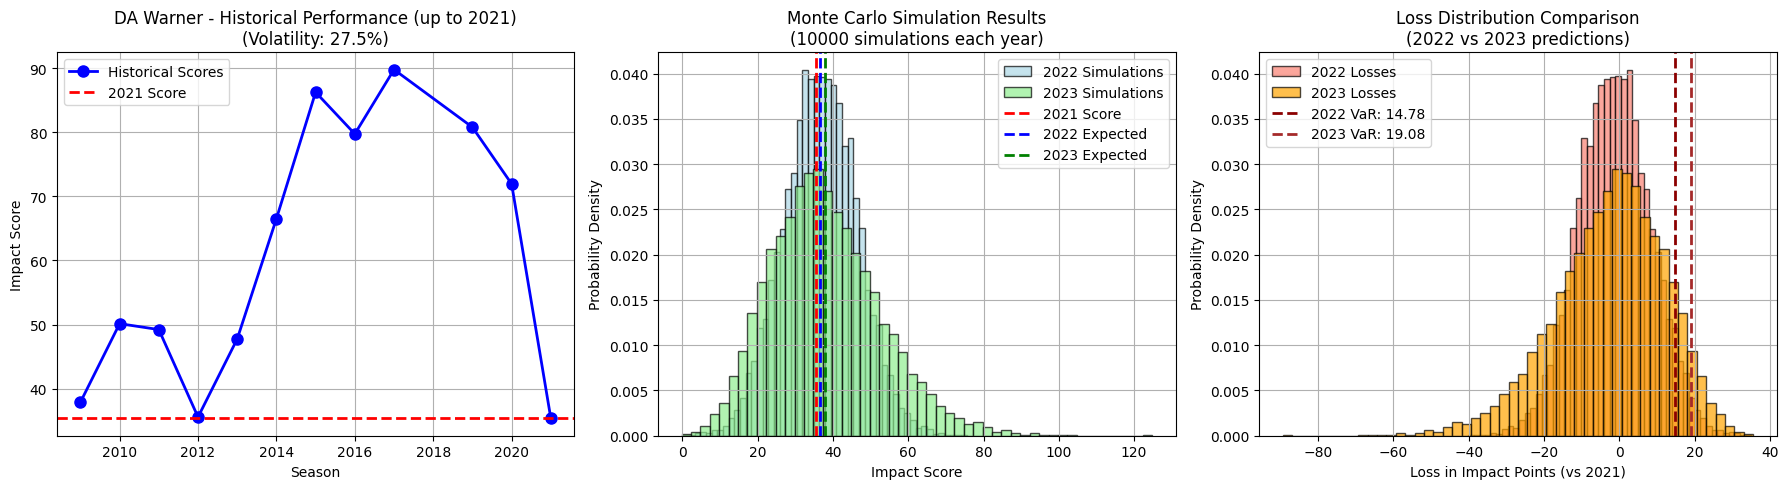

In [ ]:
# region [MONTE CARLO SIMULATION - PREDICTING FUTURE SEASONS]

# Let's use David Warner as our example player
player_name = "DA Warner"  # Make sure this matches exactly how his name appears in your data
print(f"=== ANALYZING RISK FOR {player_name} ===\n")
print("Using data up to 2021 to predict 2021 season...\n")

# Get the player's historical impact scores ONLY UP TO 2021
player_data = bowling_stats[bowling_stats['Player'] == player_name].copy()
player_data = player_data[player_data['Season'] <= 2021].sort_values('Season')  # Filter for seasons <= 2021

print(f"Historical data found for {player_name} (up to 2021):")
print(player_data[['Season', 'Bowling_Impact_Score']].to_string(index=False))
print(f"\nNumber of seasons: {len(player_data)}")

if len(player_data) < 3:
    print(f"Not enough data for {player_name}. Need at least 3 seasons.")
else:
    # Calculate historical returns (year-to-year percentage change)
    scores = player_data['Bowling_Impact_Score'].values
    print(f"\nRaw Impact Scores: {scores}")
    
    # Calculate percentage changes between seasons
    returns = np.diff(scores) / scores[:-1]
    print(f"Year-to-Year Percentage Changes: {returns}")
    
    # Calculate mean and standard deviation of returns
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    print(f"\nAverage Yearly Change: {mean_return:.3f} ({mean_return*100:.1f}%)")
    print(f"Volatility of Changes (Std Dev): {std_return:.3f} ({std_return*100:.1f}%)")
    
    # Get the most recent score as our starting point (2021 season)
    current_score = scores[-1]
    print(f"\nMost Recent Impact Score (2021): {current_score:.2f}")
    
    # Monte Carlo Simulation: Simulate next season (2022)
    n_simulations = 10000
    print(f"\nRunning {n_simulations} Monte Carlo simulations for 2022 season...")
    
    # Simulate 2022 season
    simulated_returns_2022 = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores_2022 = current_score * (1 + simulated_returns_2022)
    
    # Simulate 2023 season (using the 2022 simulated scores as base)
    print(f"Running {n_simulations} Monte Carlo simulations for 2023 season...")
    simulated_returns_2023 = np.random.normal(mean_return, std_return, n_simulations)
    simulated_scores_2023 = simulated_scores_2022 * (1 + simulated_returns_2023)
    
    # Calculate VaR and CVaR for 2022
    simulated_losses_2022 = current_score - simulated_scores_2022
    var_2022 = np.percentile(simulated_losses_2022, confidence_level * 100)
    worst_losses_2022 = simulated_losses_2022[simulated_losses_2022 >= var_2022]
    cvar_2022 = np.mean(worst_losses_2022) if len(worst_losses_2022) > 0 else var_2022
    
    # Calculate VaR and CVaR for 2023
    simulated_losses_2023 = current_score - simulated_scores_2023  # Loss from 2021 baseline
    var_2023 = np.percentile(simulated_losses_2023, confidence_level * 100)
    worst_losses_2023 = simulated_losses_2023[simulated_losses_2023 >= var_2023]
    cvar_2023 = np.mean(worst_losses_2023) if len(worst_losses_2023) > 0 else var_2023

    print(f"\n=== RISK ANALYSIS RESULTS ===")
    print(f"Player: {player_name}")
    print(f"Current Impact Score (2021): {current_score:.2f}")
    print(f"\n--- 2022 PREDICTION ---")
    print(f"Expected 2022 Score: {np.mean(simulated_scores_2022):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores_2022):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var_2022:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar_2022:.2f} points")
    
    print(f"\n--- 2023 PREDICTION ---")
    print(f"Expected 2023 Score: {np.mean(simulated_scores_2023):.2f}")
    print(f"Score Volatility: {np.std(simulated_scores_2023):.2f}")
    print(f"VaR ({confidence_level*100:.0f}% confidence): {var_2023:.2f} points")
    print(f"CVaR (Average of worst {100-confidence_level*100:.0f}% scenarios): {cvar_2023:.2f} points")
    
    # Interpretation
    print(f"\n=== INTERPRETATION ===")
    print(f"2022: {confidence_level*100:.0f}% chance of not losing more than {var_2022:.2f} points vs 2021")
    print(f"2023: {confidence_level*100:.0f}% chance of not losing more than {var_2023:.2f} points vs 2021")

# endregion

# region [VISUALIZE THE RESULTS FOR BOTH YEARS]
if len(player_data) >= 3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Historical performance up to 2021
    seasons = player_data['Season'].values
    ax1.plot(seasons, scores, 'bo-', label='Historical Scores', markersize=8, linewidth=2)
    ax1.axhline(y=current_score, color='r', linestyle='--', label='2021 Score', linewidth=2)
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Impact Score')
    ax1.set_title(f'{player_name} - Historical Performance (up to 2021)\n(Volatility: {std_return*100:.1f}%)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Monte Carlo simulation results for 2022 and 2023
    ax2.hist(simulated_scores_2022, bins=50, alpha=0.7, color='lightblue', edgecolor='black', 
             label='2022 Simulations', density=True)
    ax2.hist(simulated_scores_2023, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', 
             label='2023 Simulations', density=True)
    ax2.axvline(x=current_score, color='r', linestyle='--', label='2021 Score', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores_2022), color='blue', linestyle='--', label='2022 Expected', linewidth=2)
    ax2.axvline(x=np.mean(simulated_scores_2023), color='green', linestyle='--', label='2023 Expected', linewidth=2)
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Probability Density')
    ax2.set_title(f'Monte Carlo Simulation Results\n({n_simulations} simulations each year)')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Loss distribution comparison
    ax3.hist(simulated_losses_2022, bins=50, alpha=0.7, color='salmon', edgecolor='black', 
             label='2022 Losses', density=True)
    ax3.hist(simulated_losses_2023, bins=50, alpha=0.7, color='orange', edgecolor='black', 
             label='2023 Losses', density=True)
    ax3.axvline(x=var_2022, color='darkred', linestyle='--', linewidth=2, 
                label=f'2022 VaR: {var_2022:.2f}')
    ax3.axvline(x=var_2023, color='brown', linestyle='--', linewidth=2,
                label=f'2023 VaR: {var_2023:.2f}')
    ax3.set_xlabel('Loss in Impact Points (vs 2021)')
    ax3.set_ylabel('Probability Density')
    ax3.set_title('Loss Distribution Comparison\n(2022 vs 2023 predictions)')
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

# endregion

In [ ]:
# Step 1: Identify players who played in 2025
Players_2025 = df_season_perf[df_season_perf['Season'] == 2025]['Player'].unique()
print(f"Number of players who played in 2025: {len(Players_2025)}")


Number of players who played in 2025: 200


## Till 2024

In [59]:
# region [PREDICT 2025 RISK USING HISTORICAL DATA (2008-2024)]

# Step 1: Identify players who played in 2025
players_in_2025 = bowling_stats[bowling_stats['Season'] == 2025]['Player'].unique()
print(f"Number of players who batted in 2025: {len(players_in_2025)}")


Number of players who batted in 2025: 200


In [60]:

# Step 2: Prepare historical data (2008-2024 only)
historical_data = bowling_stats[bowling_stats['Season'] != 2025].copy()

# Step 3: Run Monte Carlo simulation for each player to predict 2025 risk
results_2025 = []

for player in players_in_2025:
    # Get player's historical data (excluding 2025)
    player_historical = historical_data[historical_data['Player'] == player].sort_values('Season')
    
    if len(player_historical) >= 3:  # Need sufficient data for meaningful simulation
        result = calculate_player_risk(player, historical_data, 'Bowling_Impact_Score')
        if result:
            # Get their actual 2025 performance for comparison
            actual_2025 = bowling_stats[(bowling_stats['Player'] == player) & 
                                            (bowling_stats['Season'] == 2025)]
            actual_score_2025 = actual_2025['Bowling_Impact_Score'].values[0] if not actual_2025.empty else np.nan
            
            results_2025.append({
                'Player': player,
                'Seasons_Available': len(player_historical),
                'Last_Historical_Score': player_historical['Bowling_Impact_Score'].iloc[-1],
                'Predicted_Expected_Score': result['expected_score'],
                'Predicted_VaR_95': result['var'],
                'Predicted_CVaR_95': result['cvar'],
                'Actual_2025_Score': actual_score_2025,
                'Prediction_Error': actual_score_2025 - result['expected_score'] if not np.isnan(actual_score_2025) else np.nan
            })
    else:
        print(f"Insufficient data for {player}: only {len(player_historical)} seasons")

# Step 4: Create the output DataFrame
risk_predictions_2025 = pd.DataFrame(results_2025)


Insufficient data for A Kamboj: only 1 seasons
Insufficient data for A Mhatre: only 0 seasons
Insufficient data for A Raghuvanshi: only 1 seasons
Insufficient data for Abishek Porel: only 2 seasons
Insufficient data for Akash Madhwal: only 2 seasons
Insufficient data for Akash Singh: only 2 seasons
Insufficient data for Aniket Verma: only 0 seasons
Insufficient data for Arshad Khan: only 2 seasons
Insufficient data for Ashutosh Sharma: only 1 seasons
Insufficient data for Ashwani Kumar: only 0 seasons
Insufficient data for Atharva Taide: only 2 seasons
Insufficient data for Azmatullah Omarzai: only 1 seasons
Insufficient data for BKG Mendis: only 0 seasons
Insufficient data for C Bosch: only 0 seasons
Insufficient data for D Brevis: only 2 seasons
Insufficient data for D Ferreira: only 1 seasons
Insufficient data for DP Conway: only 2 seasons
Insufficient data for DS Rathi: only 0 seasons
Insufficient data for Dhruv Jurel: only 2 seasons
Insufficient data for E Malinga: only 0 seasons


In [61]:
risk_predictions_2025.head(10)

,Player,Seasons_Available,Last_Historical_Score,Predicted_Expected_Score,Predicted_VaR_95,Predicted_CVaR_95,Actual_2025_Score,Prediction_Error
0,A Badoni,3,NaN,NaN,NaN,NaN,41.524476,NaN
1,A Manohar,3,NaN,NaN,NaN,NaN,NaN,NaN
2,A Nortje,5,40.753247,35.544537,12.875203,14.784641,30.886156,-4.658381
3,A Zampa,4,42.699515,39.545525,26.409968,31.956999,34.664627,-4.880898
4,AD Russell,12,69.977753,NaN,NaN,NaN,49.735373,NaN
5,AK Markram,4,NaN,NaN,NaN,NaN,43.137622,NaN
6,AM Rahane,16,NaN,NaN,NaN,NaN,NaN,NaN
7,AR Patel,11,54.207792,54.692222,29.465299,37.519621,45.897080,-8.795142
8,AS Roy,4,29.078104,25.863547,6.330238,7.120132,42.225233,16.361686
9,Abdul Samad,5,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
risk_predictions_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Player                    116 non-null    object 
 1   Seasons_Available         116 non-null    int64  
 2   Last_Historical_Score     70 non-null     float64
 3   Predicted_Expected_Score  49 non-null     float64
 4   Predicted_VaR_95          49 non-null     float64
 5   Predicted_CVaR_95         49 non-null     float64
 6   Actual_2025_Score         68 non-null     float64
 7   Prediction_Error          47 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.4+ KB



Successfully analyzed 116 players

Top 10 players with highest predicted risk (VaR):
             Player  Predicted_VaR_95  VaR_Relative_Pct
115      Yash Dayal         90.997106        142.683319
59        MM Sharma         86.819957        139.651865
101     T Natarajan         80.824032        111.724921
63   Mohammed Shami         78.466968         97.188587
26         HV Patel         75.753902         81.794791
34        JJ Bumrah         75.639528         97.350057
45    Kuldeep Yadav         72.677621        112.827780
71       PJ Cummins         64.705435         96.642965
17         CV Varun         56.189868         74.492433
103        TA Boult         48.907959         75.935960

Top 10 players with lowest predicted risk (VaR):
            Player  Predicted_VaR_95  VaR_Relative_Pct
8           AS Roy          6.330238         21.769775
38    K Khejroliya          8.386481         41.267289
16      C Sakariya         10.668356         37.584396
53    M Theekshana         1

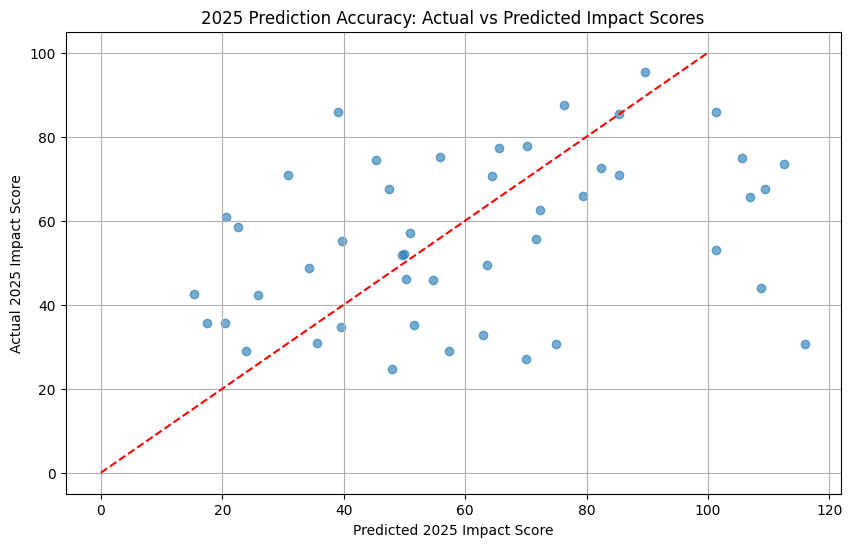

In [63]:

# Calculate additional risk metrics
risk_predictions_2025['VaR_Relative_Pct'] = (risk_predictions_2025['Predicted_VaR_95'] / 
                                           risk_predictions_2025['Last_Historical_Score']) * 100
risk_predictions_2025['CVaR_Relative_Pct'] = (risk_predictions_2025['Predicted_CVaR_95'] / 
                                            risk_predictions_2025['Last_Historical_Score']) * 100

# Step 5: Analyze the results
print(f"\nSuccessfully analyzed {len(risk_predictions_2025)} players")
print("\nTop 10 players with highest predicted risk (VaR):")
print(risk_predictions_2025.sort_values('Predicted_VaR_95', ascending=False).head(10)[['Player', 'Predicted_VaR_95', 'VaR_Relative_Pct']])

print("\nTop 10 players with lowest predicted risk (VaR):")
print(risk_predictions_2025.sort_values('Predicted_VaR_95').head(10)[['Player', 'Predicted_VaR_95', 'VaR_Relative_Pct']])

# Step 6: Display the complete prediction DataFrame
print("\nComplete 2025 Risk Prediction DataFrame:")
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
print(risk_predictions_2025[['Player', 'Seasons_Available', 'Last_Historical_Score', 
                           'Predicted_Expected_Score', 'Predicted_VaR_95', 'Predicted_CVaR_95',
                           'VaR_Relative_Pct', 'Actual_2025_Score', 'Prediction_Error']].sort_values('Predicted_VaR_95', ascending=False))

# Reset display options
pd.reset_option('display.max_rows')
pd.reset_option('display.float_format')

# endregion

# region [ANALYZE PREDICTION ACCURACY]
# Check how well our predictions matched reality for 2025
if not risk_predictions_2025['Prediction_Error'].isna().all():
    mean_error = risk_predictions_2025['Prediction_Error'].mean()
    mean_absolute_error = risk_predictions_2025['Prediction_Error'].abs().mean()
    rmse = np.sqrt((risk_predictions_2025['Prediction_Error'] ** 2).mean())
    
    print(f"\nPrediction Accuracy Analysis:")
    print(f"Mean Error: {mean_error:.2f} (negative = average overprediction)")
    print(f"Mean Absolute Error: {mean_absolute_error:.2f}")
    print(f"Root Mean Square Error: {rmse:.2f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(risk_predictions_2025['Predicted_Expected_Score'], 
                risk_predictions_2025['Actual_2025_Score'], alpha=0.6)
    plt.plot([0, 100], [0, 100], 'r--')  # Perfect prediction line
    plt.xlabel('Predicted 2025 Impact Score')
    plt.ylabel('Actual 2025 Impact Score')
    plt.title('2025 Prediction Accuracy: Actual vs Predicted Impact Scores')
    plt.grid(True)
    plt.show()
else:
    print("No actual 2025 data available for accuracy analysis")

# endregion

In [64]:
df_sorted = risk_predictions_2025.sort_values(by="Prediction_Error", ascending=False)

df_sorted.head(20)

,Player,Seasons_Available,Last_Historical_Score,Predicted_Expected_Score,Predicted_VaR_95,Predicted_CVaR_95,Actual_2025_Score,Prediction_Error,VaR_Relative_Pct,CVaR_Relative_Pct
37,JR Hazlewood,4,31.714907,39.114245,25.955255,34.200764,85.789548,46.675303,81.839292,107.838133
31,JC Archer,4,24.798641,20.581022,19.024379,22.991181,60.968063,40.387041,76.715412,92.711456
49,M Jansen,4,30.567718,30.833030,15.069108,19.006235,70.984425,40.151395,49.297457,62.177475
53,M Theekshana,3,31.348794,22.621716,11.024812,11.625242,58.427364,35.805648,35.168218,37.083539
40,KH Pandya,9,43.289425,45.345445,24.477180,31.113039,74.440323,29.094878,56.543093,71.872146
46,L Ngidi,3,25.076479,15.398919,12.850480,13.659746,42.446678,27.047759,51.245151,54.472345
93,SN Thakur,9,37.914136,47.402902,36.420927,47.879104,67.533254,20.130353,96.061605,126.282988
14,B Kumar,14,51.442171,55.847647,29.557837,39.083151,75.241550,19.393903,57.458378,75.974925
38,K Khejroliya,3,20.322347,17.492594,8.386481,9.798817,35.733197,18.240604,41.267289,48.216959
8,AS Roy,4,29.078104,25.863547,6.330238,7.120132,42.225233,16.361686,21.769775,24.486232
